**Book Review - An Exploratory Data Analysis and Data Transformation Notebook**

**Author: Satyajit Ghana**

---



In [ ]:
# System
import warnings
import os
warnings.filterwarnings("ignore")
%matplotlib inline

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

---

# **Book Crossing EDA**

In [ ]:
%matplotlib inline

import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer

sns.set()
palette = sns.color_palette("icefire")

plt.style.use('ggplot')

sns.set_context("talk")

## Loading, Cleaning and Merging the Dataset

Reading the csv files

The dataset is semi-colon separated instead of semi-colon separated, and als the incoding is `ISO-8859-1`

In [ ]:
users = pd.read_csv(
    '/kaggle/input/bookcrossing-dataset/Book reviews/BX-Users.csv', 
    names=['user_id', 'location', 'age'], 
    sep=';',
    skiprows=1,
    encoding='ISO-8859-1', 
    low_memory=False, 
    error_bad_lines=False
)
users

parse the datatypes properly

In [ ]:
users.dtypes

A quick look at the numeric attributes of the users table

In [ ]:
users.describe().T

**Data Inconsistency**

We notice that the max age is 244, and min age is 0, age cannot be 244 ! so let's fix that, also minimum age cannot be 0, this is likely a mistake during data collection, and missing age values were probably just replaced by 0, so we'll have to fix that

one way is to simply replace the inconsitent values with the mean of the data

In [ ]:
users.loc[(users.age > 100) | (users.age < 5), 'age'] = np.nan
users.age = users.age.fillna(users.age.mean())

In [ ]:
users['age'] = users['age'].astype(np.uint8)

In [ ]:
users['age'].describe()

checking for any `NA` values

In [ ]:
users.isna().sum()

Now we'll read the books data, same way as before

In [ ]:
books = pd.read_csv(
    '/kaggle/input/bookcrossing-dataset/Book reviews/BX_Books.csv',
    names=['isbn', 'book_title', 'book_author', 'year_of_publication', 'publisher', 'img_s', 'img_m', 'img_l'], 
    sep=';',
    skiprows=1,
    encoding='ISO-8859-1', 
    low_memory=False, 
    error_bad_lines=False
)
books

parse the data types properly

In [ ]:
books.dtypes

**Dropping Unnecessary Values**

drop `['img_s', 'img_m', 'img_l']` since they are not useful for us

In [ ]:
books = books.drop(['img_s', 'img_m', 'img_l'], axis=1)

`year_of_publication` should be a integer

In [ ]:
books['year_of_publication'] = pd.to_numeric(books['year_of_publication'], errors='coerce')

In [ ]:
books.loc[(books['year_of_publication'] == 0) | (books['year_of_publication'] > 2008), 'year_of_publication' ] = np.nan
books['year_of_publication'] = books['year_of_publication'].fillna(round(books['year_of_publication'].mean()))
books['year_of_publication'] = pd.to_numeric(books['year_of_publication'], downcast='unsigned')

Checking for any `NA` values

In [ ]:
books.isna().sum()

Since the `NA` rows are very few, we'll simply drop them

In [ ]:
books = books.dropna()

In [ ]:
books.describe().T

Read the ratings dataset as usual

In [ ]:
ratings = pd.read_csv(
    '/kaggle/input/bookcrossing-dataset/Book reviews/BX-Book-Ratings.csv',
    names=['user_id', 'isbn', 'book_rating'],
    sep=';',
    skiprows=1,
    encoding='ISO-8859-1', 
    low_memory=False, 
    error_bad_lines=False
)
ratings

In [ ]:
ratings['book_rating'] = ratings['book_rating'].astype(np.uint8)

In [ ]:
ratings.dtypes

check for any `NA` values

In [ ]:
ratings.isna().sum()

There are some inconsistent values, which we will fix later

In [ ]:
ratings.describe().T.astype(np.int32)

Join the three datasets based on `user_id` and `isbn` as the key

In [ ]:
temp = pd.merge(users, ratings, on='user_id')
temp = pd.merge(temp, books, on='isbn')
dataset = temp.copy()

In [ ]:
dataset

Split the location into `city`, `state` and `country` and replacing missing location details with just `n/a`

We might use these attributes at a later stage of the assignment in collborative filtering, for now it seems useful so we'll keep them.

In [ ]:
location = dataset['location'].str.split(', ', n=2, expand=True)
location.columns = ['city', 'state', 'country']
location = location.fillna('n/a')

In [ ]:
dataset['city'] = location['city'] ; dataset['state'] = location['state'] ; dataset['country'] = location['country']

In [ ]:
dataset = dataset.drop(['location'], axis=1)

In [ ]:
dataset.describe().T.astype(np.int32)

checking for `NA` values

In [ ]:
dataset.isna().sum()

So we have `1,031,172` values in total, that's a lot !

In [ ]:
dataset.shape

In [ ]:
dataset.dtypes

This will be the final dataset we will be working with !

In [ ]:
dataset.head(5)

In [ ]:
dataset.info()

In [ ]:
cleaned_data = dataset.copy()

In [ ]:
# dataset = cleaned_data.copy()

---

## Analyzing the Feature Space

In [ ]:
def get_skewness(data, columns):
    """returns the skewness and kurtosis of the specified attributes"""
    skewness = data[columns].skew()
    kurtosis = data[columns].kurtosis()

    df = {
        'skewness': skewness.values,
        'kurtosis': kurtosis.values
    }

    dataframe = pd.DataFrame(data=df, index=columns)

    return dataframe

In [ ]:
f, axes = plt.subplots(ncols = 4, figsize=(25, 5))
sns.kdeplot(data=dataset['book_rating'], ax=axes[0]).set_title('rating_distr')
sns.kdeplot(data=dataset[dataset['book_rating'] != 0]['book_rating'], ax=axes[1]).set_title('explicit rating_distr')
sns.boxplot(y="book_rating", data=dataset, orient='v', ax=axes[2]).set_title('rating_distr')
sns.boxplot(y="book_rating", data=dataset[dataset['book_rating'] != 0], orient='v', ax=axes[3]).set_title('explicit rating_distr')
plt.show()

Something we can clearly notice in `rating_distr` is that 0 ratings are a lot ! and when we drop them to get `explicit_rating_distr`, the distribution is lot better, even the box plot is better, so it makes sense to remove the 0 rated values

Why would someone rate a book 0 ? this likely are the values for user that forgot to rate the book, people are lazy right ?

For normally distributed data, the skewness should be about zero. For unimodal continuous distributions, a skewness value greater than zero means that there is more weight in the right tail of the distribution. The function skewtest can be used to determine if the skewness value is close enough to zero, statistically speaking.

In [ ]:
get_skewness(dataset, ['age', 'book_rating'])

In [ ]:
dataset[['age', 'book_rating']].describe().T

We can remove `0` ratings, since these are unrated, and why would someone rate a book as `0` ?

In [ ]:
dataset = dataset[dataset['book_rating'] != 0]

We notice that skewness of the `book_rating` changes from a strong positive, to negative !

In [ ]:
get_skewness(dataset, ['age', 'book_rating'])

In [ ]:
dataset[['age', 'book_rating']].describe().T

---

### Univariate Analysis of Attributes

Here we plot the Distribution, Box Plot, Violin Plot and QQ Plot for the numeric attributes `age` and `book_rating`

In [ ]:
def plot_univariate(dataset, column_name, suptitle = None, kde_only = True):
    f, axes = plt.subplots(ncols = 4, figsize=(25, 5))
    if kde_only:
        sns.kdeplot(data=dataset[column_name], ax=axes[0]).set_title(f'{column_name}_distr')
    else:
        sns.histplot(data=dataset[column_name], kde=True, ax=axes[0]).set_title(f'{column_name}_distr')
    sns.boxplot(y=column_name, data=dataset, orient='v', ax=axes[1]).set_title(f'{column_name}_box_plot')
    sns.violinplot(y=column_name, data=dataset, orient='v', ax=axes[2]).set_title(f'{column_name}_violin_plot')
    scipy.stats.probplot(dataset[column_name], dist="norm", plot=axes[3])
    if suptitle:
        plt.suptitle(suptitle)
        plt.subplots_adjust(top=0.80)
    plt.show()

In [ ]:
sns.kdeplot(data=dataset['book_rating'])

In [ ]:
dataset['book_rating'].astype(np.float32)

In [ ]:
plot_univariate(dataset=dataset, column_name='book_rating', suptitle='Book Rating')

In [ ]:
plot_univariate(dataset=dataset, column_name='age', suptitle='Age')

**Inference**

- `book_rating`

    We see that the distribution of books is not normal, also the box plot shows outliers in the lower region, ratings from 1 to 4, the probability plot also confirms this, this is something we deal with outlier analysis later

- `age`

    Age has a peak density about 30-34, the box-plot shows a lot of outlisers, and the qq plot also

## Outlier Analysis and removing them

We'll try to infer the outliers using the `IsolationForest` algorithm,

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies. (Scikit-learn)

1. It classify the data point to outlier and not outliers and works great with very high dimensional data.
2. It works based on decision tree and it isolate the outliers.
3. If the result is -1, it means that this specific data point is an outlier. If the result is 1, then it means that the data point is not an outlier.

In [ ]:
def plot_isolation_forest(data, columns, suptitle = None):
    ncols = len(columns)
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(len(columns) * 8, 5))
    isolation_forest = IsolationForest(contamination='auto')
    for i, column in enumerate(columns):
        isolation_forest.fit(data[column].values.reshape(-1, 1))

        xx = np.linspace(data[column].min(), data[column].max(), len(data[column])).reshape(-1, 1)
        anomaly_score = isolation_forest.decision_function(xx)
        outlier = isolation_forest.predict(xx)

        axes[i].plot(xx, anomaly_score, label='anomaly_score')
        axes[i].fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score),
                             where=outlier == -1, color='r',
                             alpha=.4, label='outlier_region')
        axes[i].legend()
        axes[i].set_title(column)

    if suptitle:
        plt.suptitle(suptitle)
        plt.subplots_adjust(top=0.80)

In [ ]:
plot_isolation_forest(data=dataset, columns=['age', 'book_rating'], suptitle='Isolation Forest')

Isolation Forest shows us that a lot of data in our range contains anomalies

---

### Drop Outliers with IQR

In this method by using Inter Quartile Range (IQR), we detect outliers. IQR tells us the variation in the data set. Any value, which is beyond the range of $-1.5 \times IQR$ to $1.5 \times IQR$ treated as outliers

In [ ]:
def drop_outliers(data, columns):
    data_new = data.copy()
    
    for column in columns:
        iqr = 1.5 * (np.percentile(data_new[column], 75) - np.percentile(data_new[column], 25))
        data_new.drop(data_new[data_new[column] > (iqr + np.percentile(data_new[column], 75))].index, inplace=True)
        data_new.drop(data_new[data_new[column] < (np.percentile(data_new[column], 25) - iqr)].index, inplace=True)
    
    return data_new

In [ ]:
dataset_wo_outliers = drop_outliers(dataset, ['age', 'book_rating'])

In [ ]:
dataset_wo_outliers[['age', 'book_rating']].describe().T

In [ ]:
get_skewness(dataset_wo_outliers, ['age', 'book_rating'])

In [ ]:
plot_univariate(dataset=dataset_wo_outliers, column_name='book_rating', suptitle='Book Rating')

In [ ]:
plot_univariate(dataset=dataset_wo_outliers, column_name='age', suptitle='Age')

In [ ]:
plot_isolation_forest(data=dataset_wo_outliers, columns=['age', 'book_rating'], suptitle='Isolation Forest')

### BoxCox

A Box Cox transformation is a transformation of a non-normal dependent variables into a normal shape. Normality is an important assumption for many statistical techniques; if your data isn’t normal, applying a Box-Cox means that you are able to run a broader number of tests.

The BoxCox transformation is given by

```
y = (x**lmbda - 1) / lmbda,  for lmbda > 0
    log(x),                  for lmbda = 0
```

The confidence limits returned when alpha is provided give the interval where:

$$llf(\hat{\lambda}) - llf(\lambda) < \frac{1}{2}\chi^2(1-\alpha, 1)$$

with `llf` the log-likelihood function and  the chi-squared function.

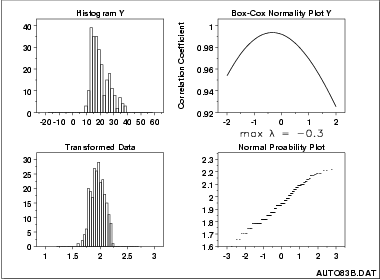

In [ ]:
def apply_boxcox(data, columns):
    data_new = data.copy()
    
    for column in columns:
        data_new[column], _ = scipy.stats.boxcox(data_new[column].astype(np.float32), lmbda=None)
    
    return data_new

In [ ]:
dataset_boxcox = apply_boxcox(dataset, ['age', 'book_rating'])

In [ ]:
dataset_boxcox[['age', 'book_rating']].describe().T

In [ ]:
get_skewness(dataset_boxcox, ['age', 'book_rating'])

In [ ]:
plot_univariate(dataset=dataset_boxcox, column_name='book_rating', suptitle='Book Rating')

In [ ]:
plot_univariate(dataset=dataset_boxcox, column_name='age', suptitle='Age')

In [ ]:
plot_isolation_forest(data=dataset_boxcox, columns=['age', 'book_rating'], suptitle='Isolation Forest')

### Imputation

Another types of outliers are caused by missing values, for which one type of imputation algorithm is univariate, which imputes values in the i-th feature dimension using only non-missing values in that feature dimension (e.g. `impute.SimpleImputer`). (Scikit-learn)

In [ ]:
def apply_imputation(data, columns):
    data_new = data.copy()

    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

    for column in columns:
        data_new[column] = imputer.fit_transform(data_new[column].astype(np.float32).values.reshape(-1, 1))
    
    return data_new

In [ ]:
dataset_imputed = apply_imputation(data=dataset, columns=['age', 'book_rating'])

In [ ]:
dataset_imputed[['age', 'book_rating']].describe().T

In [ ]:
get_skewness(dataset_imputed, ['age', 'book_rating'])

In [ ]:
plot_univariate(dataset=dataset_imputed, column_name='book_rating', suptitle='Book Rating')

In [ ]:
plot_univariate(dataset=dataset_imputed, column_name='age', suptitle='Age')

In [ ]:
plot_isolation_forest(data=dataset_imputed, columns=['age', 'book_rating'], suptitle='Isolation Forest')

You'll observe that imputation didn't help us much, since our data does not have `nan` values, but this is a demonstration that imputation can also be used

---

## Data Transformation

In [ ]:
dataset_trans = dataset_wo_outliers.copy()

In [ ]:
def apply_function(data, columns, function):
    data_new = data.copy()

    for column in columns:
        data_new[column] = function(data_new[column])

    return data_new

### Min-Max Normalization

This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.

The transformation is given by:

```python
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min
```
where `min, max = feature_range`.

This transformation is often used as an alternative to zero mean, unit variance scaling.

The mathematical formula being:

$$x_{scaled} = \frac{x-x_{min}}{x_{max}-x_{min}}$$

In [ ]:
def min_max_scaling(series):
    scaler = MinMaxScaler()
    scaled_vals = scaler.fit_transform(series.values.reshape(-1, 1)).reshape(-1)
    return scaled_vals

In [ ]:
scaled_dset = apply_function(dataset_trans, ['age', 'book_rating'], min_max_scaling)
scaled_dset[['age', 'book_rating']]

In [ ]:
scaled_dset[['age', 'book_rating']].describe().T

In [ ]:
get_skewness(scaled_dset, ['book_rating', 'age'])

In [ ]:
plot_univariate(dataset=scaled_dset, column_name='book_rating', suptitle='MinMax Scaler')

In [ ]:
plot_univariate(dataset=scaled_dset, column_name='age', suptitle='MinMax Scaler')

**Inference**

- The skewness has now becomes `-0.34` for book_rating and `0.35` for age

### Z-Score Standardization


Standardize features by removing the mean and scaling to unit variance

The standard score of a sample `x` is calculated as:

$$z = \frac{x-\mu}{\sigma}$$

where u is the mean of the training samples or zero if `with_mean=False`, and s is the standard deviation of the training samples or one if `with_std=False`.

Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Mean and standard deviation are then stored to be used on later data using transform.

Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).

For instance many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the L1 and L2 regularizers of linear models) assume that all features are centered around 0 and have variance in the same order. If a feature has a variance that is orders of magnitude larger that others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected. (Scikit-learn)

In [ ]:
def z_score_scaling(series):
    scaler = StandardScaler()
    scaled_vals = scaler.fit_transform(series.values.reshape(-1, 1)).reshape(-1)
    return scaled_vals

In [ ]:
scaled_dset = apply_function(dataset_trans, ['age', 'book_rating'], z_score_scaling)
scaled_dset[['age', 'book_rating']]

In [ ]:
scaled_dset[['age', 'book_rating']].describe().T

In [ ]:
get_skewness(scaled_dset, ['book_rating', 'age'])

In [ ]:
plot_univariate(dataset=scaled_dset, column_name='book_rating', suptitle='Z-Score Scaler')

In [ ]:
plot_univariate(dataset=scaled_dset, column_name='age', suptitle='Z-Score Scaler')

### Decimal Scaling

Decimal scaling is a data normalization technique like Z score, Min-Max, and normalization with standard deviation. Decimal scaling is a data normalization technique. In this technique, we move the decimal point of values of the attribute. This movement of decimal points totally depends on the maximum value among all values in the attribute.

The formula is given by:

$$v_{i}^{'} = \frac{v_i}{10^j}$$

In [ ]:
def decimal_scaling(series):
    p = series.max()
    q = len(str(abs(p)))
    scaled_vals = series.values / 10 ** q

    return scaled_vals

In [ ]:
scaled_dset = apply_function(dataset_trans, ['age', 'book_rating'], decimal_scaling)
scaled_dset[['age', 'book_rating']]

In [ ]:
scaled_dset[['age', 'book_rating']].describe().T

In [ ]:
get_skewness(scaled_dset, ['book_rating', 'age'])

In [ ]:
plot_univariate(dataset=scaled_dset, column_name='book_rating', suptitle='Decimal Scaler')

In [ ]:
plot_univariate(dataset=scaled_dset, column_name='age', suptitle='Decimal Scaler')

---

## Data Normality

When a metric variable fails to satisfy the assumption of normality, homogeneity of variance, or linearity, we may be able to crrect the deficiency by using a transformation

- If the distribution of a variable is negatively skewed the adjustment of the values reverses, or reflects, the distribution so that it becomes positively skeweed. The transformations are then computed on the values in the positively skewed distribution.

- Reflection is computed by subtracting all of the values for a variable from one plus the absolute value of maximum value for the variable. This results in a positively skewed distribution with all values larger than zero.

Which transformation? 


The main criterion in choosing a transformation is: what works with the data? As examples above indicate, it is important to consider as well two questions.


What makes physical (biological, economic, whatever) sense, for example in terms of limiting behaviour as values get very small or very large? This question often leads to the use of logarithms.

Can we keep dimensions and units simple and convenient? If possible, we prefer measurement scales that are easy to think about. The cube root of a volume and the square root of an area both have the dimensions of length, so far from complicating matters, such transformations may simplify them. Reciprocals usually have simple units, as mentioned earlier. Often, however, somewhat complicated units are a sacrifice that has to be made.

It is not always necessary or desirable to transform a data set to resemble a normal distribution. However, if symmetry or normality are desired, they can often be induced through one of the power transformations.;

### Natural Log Transform

Log transformation or $\log_{e}{x}$ is a strong transformation with a major effect on distribution shape, it is commonly used for reducing **right skewness** and is often appropriate for measured values. It cannot be applied to zero or negative values. One unit on a logarithm scale means a multiplication by the base of logarithms being used. Exponential growth or decline.

$$x_{new} = \ln{x}$$

In [ ]:
def natural_log_transform(series):
    trans_vals = np.log(series.astype(np.float32))

    return trans_vals

In [ ]:
trans_dset = apply_function(dataset_trans, ['age', 'book_rating'], natural_log_transform)
trans_dset[['age', 'book_rating']]

In [ ]:
trans_dset[['age', 'book_rating']].describe().T

In [ ]:
get_skewness(trans_dset, ['book_rating', 'age'])

In [ ]:
plot_univariate(dataset=trans_dset, column_name='book_rating', suptitle='Natural Log Transform')

In [ ]:
plot_univariate(dataset=trans_dset, column_name='age', suptitle='Natural Log Transform')

### Square Root Transform

The square root, x to x^(1/2) = sqrt(x), is a transformation with a moderate effect on distribution shape: it is weaker than the logarithm and the cube root. It is also used for reducing right skewness, and also has the advantage that it can be applied to zero values. Note that the square root of an area has the units of a length. It is commonly applied to counted data, especially if the values are mostly rather small.

$$x_{new} = \sqrt{x}$$



In [ ]:
def sqrt_transform(series):
    trans_vals = np.sqrt(series.astype(np.float32))

    return trans_vals

In [ ]:
trans_dset = apply_function(dataset_trans, ['age', 'book_rating'], sqrt_transform)
trans_dset[['age', 'book_rating']]

In [ ]:
trans_dset[['age', 'book_rating']].describe().T

In [ ]:
get_skewness(trans_dset, ['book_rating', 'age'])

**NOTE**: Skewness has a value of ~`0` for age using Square Root Transform

In [ ]:
plot_univariate(dataset=trans_dset, column_name='book_rating', suptitle='Square Root Transform')

In [ ]:
plot_univariate(dataset=trans_dset, column_name='age', suptitle='Square Root Transform')

### Inverse Square Root Transformation

The inverse square root, 1/sqrt(x) is a very strong transformation with a drastic effect on distribution shape. It can not be applied to zero values or negative values, it is not useful unless all values are positive.

$$x_{new} = \frac{1}{\sqrt{x}}$$

In [ ]:
def inv_sqrt_transform(series):
    trans_vals = np.power(series.astype(np.float32), -1/2)

    return trans_vals

In [ ]:
trans_dset = apply_function(dataset_trans, ['age', 'book_rating'], inv_sqrt_transform)
trans_dset[['age', 'book_rating']]

In [ ]:
trans_dset[['age', 'book_rating']].describe().T

In [ ]:
get_skewness(trans_dset, ['book_rating', 'age'])

In [ ]:
plot_univariate(dataset=trans_dset, column_name='book_rating', suptitle='Inverse Square Root Transform')

In [ ]:
plot_univariate(dataset=trans_dset, column_name='age', suptitle='Inverse Square Root Transform')

---

## Exploratory Data Analysis

A lot of implicit EDA has already been done above, for univariate variables, now we will go on with trying to make some meaning of other attributes of the dataset, such as `book_title`, `book_author` and `year_of_publication`

In [ ]:
# to plot values in barplot, https://stackoverflow.com/a/56780852
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

### Top 25 Years of Publication

here we try to explore what were the years with huge amount of book publication, this is done by simply counting the number of book in a given year

In [ ]:
eda = dataset['year_of_publication'].copy().value_counts().head(25).reset_index()
eda.columns = ['year_of_publication', 'count']
eda = eda.sort_values(by=['count'], ascending=False)

In [ ]:
plt.figure(figsize=(7, 10))
splot = sns.barplot(x='count', y='year_of_publication', data=eda, order=eda['year_of_publication'], orient='h', palette=palette)
show_values_on_bars(splot, h_v="h")
plt.title('Top 25 Years of Publication')
plt.show()

Turns out `2002` was the when highest number of books were published, i.e. `37985`

### Top 10 Revewed Books

Here we try to find the Books which were reviewed the most !

In [ ]:
eda = dataset['book_title'].value_counts().head(10).reset_index()
eda.columns = ['book_title', 'count']

In [ ]:
plt.figure(figsize=(7, 10))
splot = sns.barplot(x='count', y='book_title', data=eda, order=eda['book_title'], orient='h', palette=palette)
show_values_on_bars(splot, h_v="h")
plt.title('Top 10 Reviewed Books')
plt.show()

`The Lovely Bone: A Novel` turns out to be most reviewed !

### Top 25 Avg. Rated Books

If i want to buy something, one thing i try is to sort the values based on average rating, we try to do similar things for our books dataset, we find the highest reviewed books and then calculate their average rating and sort them again

In [ ]:
rating_count = dataset['book_title'].value_counts().head(25).reset_index().sort_values(by='book_title').reset_index(drop=True)
rating_count.columns = ['book_title', 'rating_count']
rating_count.head(5)

In [ ]:
rating_sum = dataset[dataset['book_title'].isin(rating_count['book_title'])].groupby(['book_title'])['book_rating'].sum().reset_index().sort_values(by=['book_title'])
rating_sum.columns = ['book_title', 'rating_sum']
rating_sum.head(5)

In [ ]:
avg_rating = pd.merge(rating_count, rating_sum, on='book_title')
avg_rating['rating_avg'] = avg_rating['rating_sum'] / avg_rating['rating_count']
avg_rating = avg_rating.sort_values(by='rating_avg', ascending=False).reset_index(drop=True)

In [ ]:
avg_rating.head(5)

In [ ]:
plt.figure(figsize=(7, 10))
splot = sns.barplot(x='rating_avg', y='book_title', data=avg_rating, order=avg_rating['book_title'], orient='h', palette=palette)
show_values_on_bars(splot, h_v="h")
plt.title('Top 25 Avg. Rated Books')
plt.show()

And it turns out `Harry Potter and the Prisoner of Azkaban (Book 3)` is average `Rated 9` !

### Top 10 Reviewed Authors

When buying books, author are a major selling point as well, a famous author has more likelihood to be bought again if he publishes a new book

In [ ]:
author_count = dataset['book_author'].value_counts().head(10).reset_index()
author_count.columns = ['book_author', 'rating_count']
author_count.head(5)

In [ ]:
plt.figure(figsize=(7, 10))
splot = sns.barplot(x='rating_count', y='book_author', data=author_count, order=author_count['book_author'], orient='h', palette=palette)
show_values_on_bars(splot, h_v="h")
plt.title('Top 10 Reviewed Authors')
plt.show()

`Stephen King` books are the most reviewed !

### Analysing `Stephen King` Books

Since `Stephen King` is one of the popular authors, we can dig more about it, starting with his most reviewed books !

In [ ]:
stephen_king = dataset[dataset['book_author'] == 'Stephen King']

In [ ]:
eda = stephen_king['book_title'].value_counts().head(10).reset_index()
eda.columns = ['book_title', 'count']

In [ ]:
plt.figure(figsize=(7, 10))
splot = sns.barplot(x='count', y='book_title', data=eda, order=eda['book_title'], orient='h', palette=palette)
show_values_on_bars(splot, h_v="h")
plt.title('Top 10 Stephen King Reviewed Books')
plt.show()

It turns out Stepen Kings'a book `Dreamcatcher` is the most reviewed book of his ! which was reviewed `204` times !

Now we can do the same for his books as we did before, i.e. calculate the average ratings of his books and sort them to see which book of Stephen King was the most average rated

In [ ]:
rating_count = stephen_king['book_title'].value_counts().head(10).reset_index().sort_values(by='book_title').reset_index(drop=True)
rating_count.columns = ['book_title', 'rating_count']
rating_sum = stephen_king[stephen_king['book_title'].isin(rating_count['book_title'])].groupby(['book_title'])['book_rating'].sum().reset_index().sort_values(by=['book_title'])
rating_sum.columns = ['book_title', 'rating_sum']
avg_rating = pd.merge(rating_count, rating_sum, on='book_title')
avg_rating['rating_avg'] = avg_rating['rating_sum'] / avg_rating['rating_count']
avg_rating = avg_rating.sort_values(by='rating_avg', ascending=False).reset_index(drop=True)

In [ ]:
avg_rating.head(5)

In [ ]:
plt.figure(figsize=(7, 10))
splot = sns.barplot(x='rating_avg', y='book_title', data=avg_rating, order=avg_rating['book_title'], orient='h', palette=palette)
show_values_on_bars(splot, h_v="h")
plt.title('Top 10 Avg. Rated Stephen King Books')
plt.show()

Green Mile was Stephen King's top avg. rated book with a avg. rating of `8`

# Bibliography

1. Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

2. G.E.P. Box and D.R. Cox, “An Analysis of Transformations”, Journal of the Royal Statistical Society B, 26, 211-252 (1964).

3. http://fmwww.bc.edu/repec/bocode/t/transint.html